In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
    make_column_selector,
)
from sklearn.utils import Bunch
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

from IPython.display import Image

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

In [3]:
df = fetch_openml(data_id=534, as_frame=True).frame

In [4]:
df = df.query("WAGE > 1 and WAGE < 30")  # snip 2 outliers

In [5]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [6]:
target_feature = "WAGE"
numeric_features = df.columns[df.dtypes != "category"].to_list()
numeric_features.remove(target_feature)
one_hot_features = df.columns[df.dtypes == "category"].to_list()
display([numeric_features, one_hot_features])

[['EDUCATION', 'EXPERIENCE', 'AGE'],
 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]

In [7]:
numeric_features_prefix = ["numeric_" + name for name in numeric_features]
one_hot_features_prefix = ["category_" + name for name in one_hot_features]
df = df.rename(columns=dict(zip(one_hot_features, one_hot_features_prefix))).rename(
    columns=dict(zip(numeric_features, numeric_features_prefix))
)

numeric_features = numeric_features_prefix
one_hot_features = one_hot_features_prefix

In [8]:
X = df.drop(columns=target_feature)
y = df[target_feature]

In [9]:
ohe_pipe = Pipeline(
    [
        (
            "ohe",
            make_column_transformer(
                (
                    OneHotEncoder(drop="if_binary"),
                    one_hot_features,
                ),
            ),
        ),
    ]
).fit(X, y)

display(ohe_pipe)

Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['category_SOUTH',
                                                   'category_SEX',
                                                   'category_UNION',
                                                   'category_RACE',
                                                   'category_OCCUPATION',
                                                   'category_SECTOR',
                                                   'category_MARR'])]))])

In [10]:
# pd.DataFrame(ohe_pipe.transform(X), columns=ohe_pipe.get_feature_names_out())

In [11]:
poly_pipe = Pipeline(
    [
        (
            "prescale",
            make_column_transformer(
                (
                    StandardScaler(),
                    numeric_features,
                ),
            ),
        ),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("postscale", StandardScaler()),
    ]
).fit(X, y)

display(poly_pipe)

Pipeline(steps=[('prescale',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['numeric_EDUCATION',
                                                   'numeric_EXPERIENCE',
                                                   'numeric_AGE'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('postscale', StandardScaler())])

In [12]:
# pd.DataFrame(
#     poly_pipe.transform(X), columns=poly_pipe.get_feature_names_out()
# )

In [13]:
feature_pipe = FeatureUnion(
    [
        ("poly", poly_pipe),
        ("ohe", ohe_pipe),
    ]
).fit(X, y)

display(feature_pipe)

FeatureUnion(transformer_list=[('poly',
                                Pipeline(steps=[('prescale',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['numeric_EDUCATION',
                                                                                   'numeric_EXPERIENCE',
                                                                                   'numeric_AGE'])])),
                                                ('poly',
                                                 PolynomialFeatures(include_bias=False)),
                                                ('postscale',
                                                 StandardScaler())])),
                               ('ohe',
                                Pipeline(steps=[('ohe',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(drop='if_binary'),
                                                                                  ['category_SOUTH',
                                                                                   'category_SEX',
                                                                                   'category_UNION',
                                                                                   'category_RACE',
                                                                                   'category_OCCUPATION',
                                                                                   'category_SECTOR',
                                                                                   'category_MARR'])]))]))])

In [14]:
# pd.DataFrame(
#     feature_pipe.transform(X), columns=feature_pipe.get_feature_names_out()
# )

In [15]:
processing_pipe = Pipeline(
    [
        ("features", feature_pipe),
        ("regression", Ridge(fit_intercept=True)),
    ]
).fit(X, y)

display(processing_pipe)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('poly',
                                                 Pipeline(steps=[('prescale',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['numeric_EDUCATION',
                                                                                                    'numeric_EXPERIENCE',
                                                                                                    'numeric_AGE'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(include_bias=False)),
                                                                 ('postscale',
                                                                  StandardScaler())])),
                                                ('ohe',
                                                 Pipeline(steps=[('ohe',
                                                                  ColumnTransformer(transformers=[('onehotencoder',
                                                                                                   OneHotEncoder(drop='if_binary'),
                                                                                                   ['category_SOUTH',
                                                                                                    'category_SEX',
                                                                                                    'category_UNION',
                                                                                                    'category_RACE',
                                                                                                    'category_OCCUPATION',
                                                                                                    'category_SECTOR',
                                                                                                    'category_MARR'])]))]))])),
                ('regression', Ridge())])

In [16]:
regression_pipe = Pipeline(
    [
        (
            "ttr",
            TransformedTargetRegressor(
                regressor=processing_pipe, func=np.log, inverse_func=np.exp
            ),
        )
    ]
).fit(X, y)

regression_pipe

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('features',
                                                                       FeatureUnion(transformer_list=[('poly',
                                                                                                       Pipeline(steps=[('prescale',
                                                                                                                        ColumnTransformer(transformers=[('standardscaler',
                                                                                                                                                         StandardScaler(),
                                                                                                                                                         ['numeric_EDUCATION',
                                                                                                                                                          'numeric_EXPERIENCE',
                                                                                                                                                          'numeric_AGE'])])),
                                                                                                                       ('poly',
                                                                                                                        PolynomialFeatures(include_bias=False)),
                                                                                                                       ('postscale',
                                                                                                                        StandardScaler())])),
                                                                                                      ('ohe',
                                                                                                       Pipeline(steps=[('ohe',
                                                                                                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                                         OneHotEncoder(drop='if_binary'),
                                                                                                                                                         ['category_SOUTH',
                                                                                                                                                          'category_SEX',
                                                                                                                                                          'category_UNION',
                                                                                                                                                          'category_RACE',
                                                                                                                                                          'category_OCCUPATION',
                                                                                                                                                          'category_SECTOR',
                                                                                                                                                          'category_MARR'])]))]))])),
                                                                      ('regression',
                                                                       Ridge())])))])

In [17]:
(train_inds, dev_inds) = train_test_split(
    range(len(df)), random_state=42, train_size=0.75
)

In [18]:
degree_list = range(1, 4)
alpha_list = 10 ** np.linspace(-5, 5, 51)
param_grid = {
    "ttr__regressor__features__poly__poly__degree": degree_list,
    "ttr__regressor__regression__alpha": alpha_list,
}

grid_search = GridSearchCV(
    estimator=regression_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(X, y)

In [19]:
grid_search.best_params_

{'ttr__regressor__features__poly__poly__degree': 3,
 'ttr__regressor__regression__alpha': 25.11886431509582}

In [20]:
regression_pipe_best = grid_search.best_estimator_.fit(X, y)
regression_pipe_best

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('features',
                                                                       FeatureUnion(transformer_list=[('poly',
                                                                                                       Pipeline(steps=[('prescale',
                                                                                                                        ColumnTransformer(transformers=[('standardscaler',
                                                                                                                                                         StandardScaler(),
                                                                                                                                                         ['numeric_EDUCATION',
                                                                                                                                                          'numeric_EXPERIENCE',
                                                                                                                                                          'numeric_AGE'])])),
                                                                                                                       ('poly',
                                                                                                                        PolynomialFeatu...
                                                                                                                                           include_bias=False)),
                                                                                                                       ('postscale',
                                                                                                                        StandardScaler())])),
                                                                                                      ('ohe',
                                                                                                       Pipeline(steps=[('ohe',
                                                                                                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                                         OneHotEncoder(drop='if_binary'),
                                                                                                                                                         ['category_SOUTH',
                                                                                                                                                          'category_SEX',
                                                                                                                                                          'category_UNION',
                                                                                                                                                          'category_RACE',
                                                                                                                                                          'category_OCCUPATION',
                                                                                                                                                          'category_SECTOR',
                                                                                                                                                          'category_MARR'])]))]))])),
                                                                      ('regression',
                                                 

In [28]:
results_df = pd.DataFrame(grid_search.cv_results_["params"]).join(
    pd.DataFrame({"mean_test_score": grid_search.cv_results_["mean_test_score"]})
)

results_df.columns = [name.split("__")[-1] for name in results_df.columns]
results_df

,degree,alpha,mean_test_score
0,1,0.000010,-21.064890
1,1,0.000016,-21.064887
2,1,0.000025,-21.064883
3,1,0.000040,-21.064876
4,1,0.000063,-21.064864
...,...,...,...
148,3,15848.931925,-24.840797
149,3,25118.864315,-24.989197
150,3,39810.717055,-25.088323
151,3,63095.734448,-25.153307


In [31]:
best_poly_degree = grid_search.best_params_[list(grid_search.best_params_.keys())[0]]
best_alpha = grid_search.best_params_[list(grid_search.best_params_.keys())[1]]

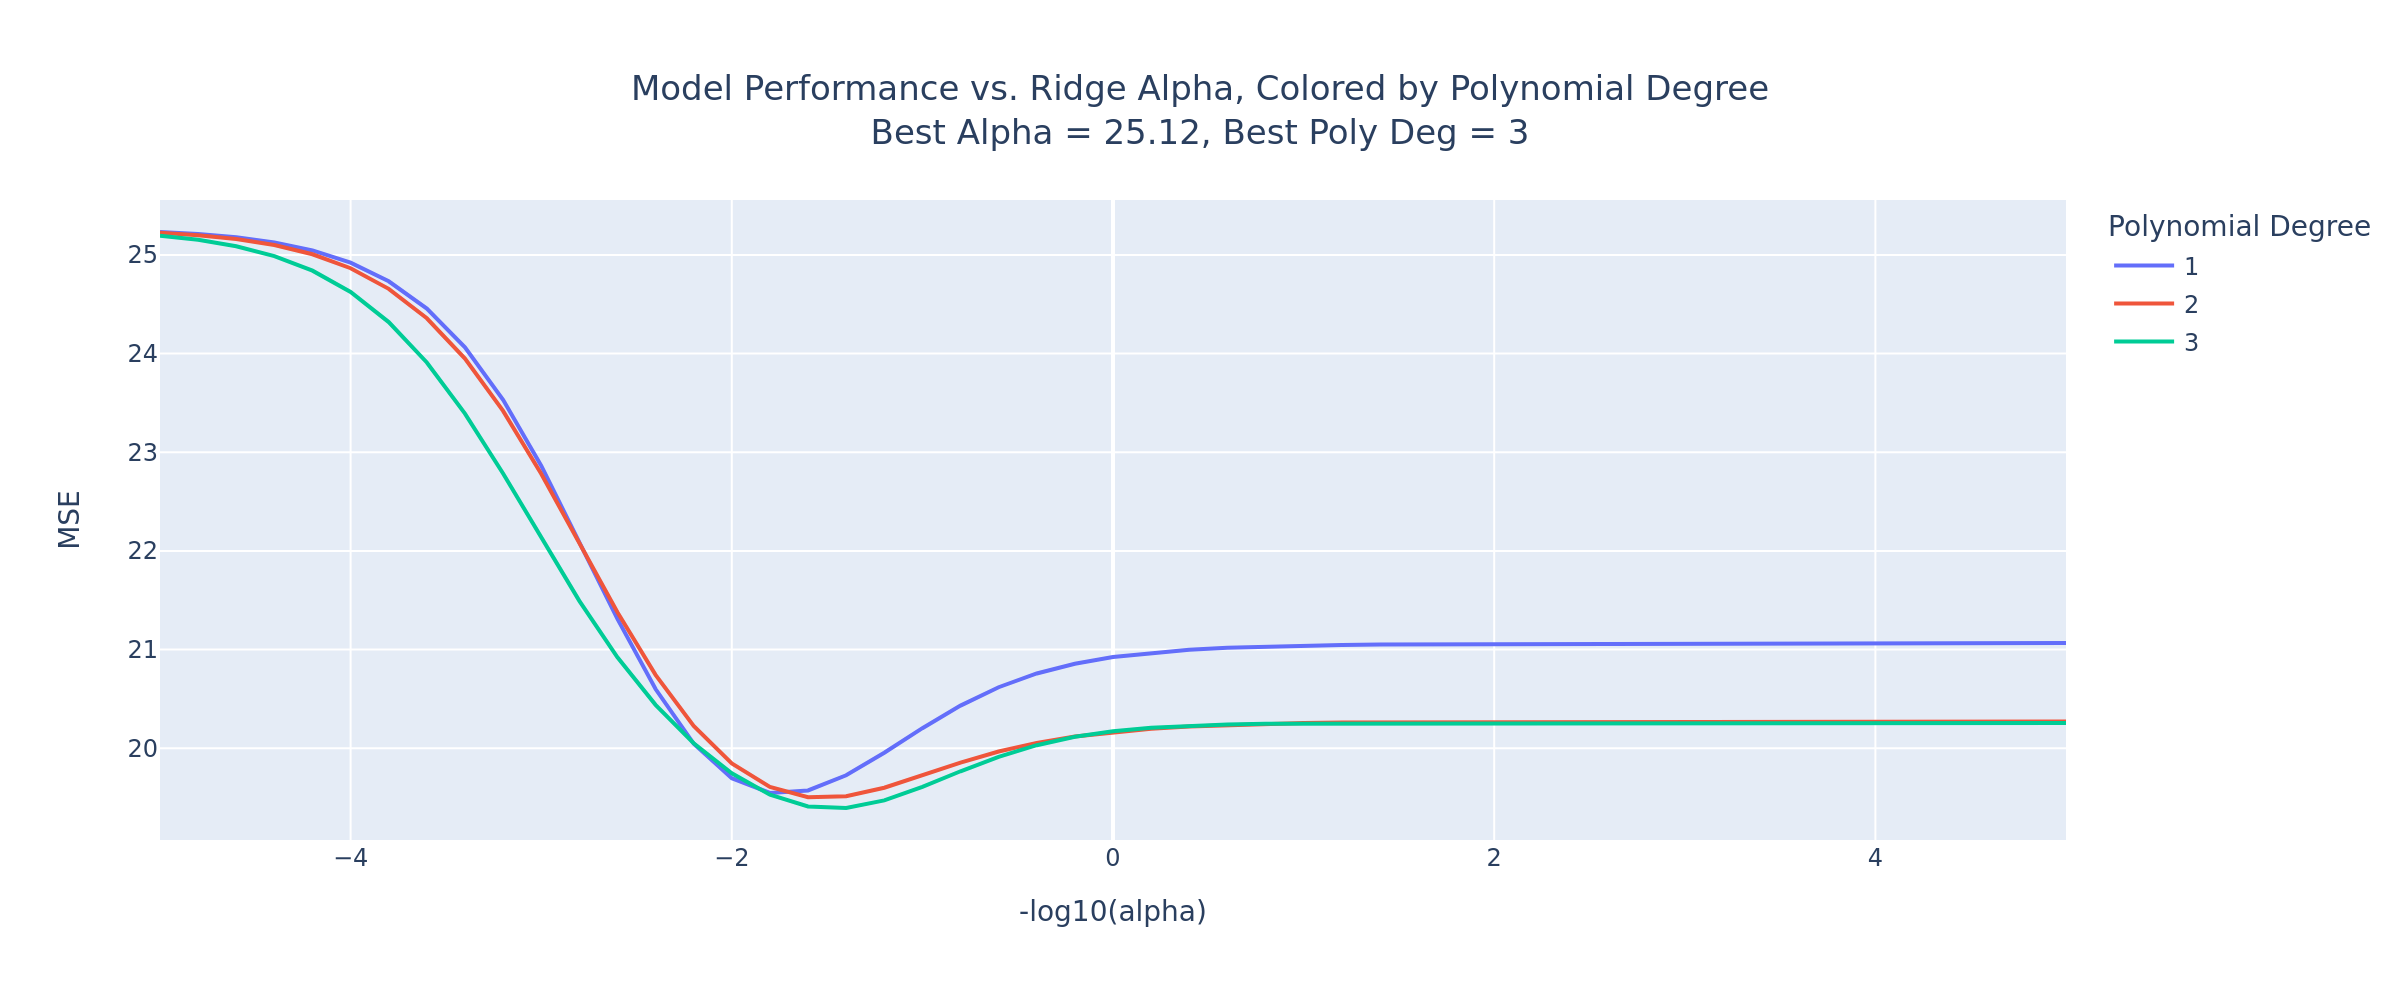

In [32]:
fig = px.line(
    results_df,
    x=-np.log10(results_df["alpha"]),
    y=-results_df["mean_test_score"],
    labels={
        "x": "-log10(alpha)",
        "y": "MSE",
        "degree": "Polynomial Degree",
    },
    title="Model Performance vs. Ridge Alpha, Colored by Polynomial Degree<br>Best Alpha = %.2f, Best Poly Deg = %d"
    % (best_alpha, best_poly_degree),
    color="degree",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

In [21]:
y_pred = regression_pipe.predict(X)
y_pred_best = regression_pipe_best.predict(X)

In [22]:
mse_basic = mean_squared_error(y, y_pred)  # was - 18.416299035907095
mse_best = mean_squared_error(regression_pipe_best.predict(X), y)
[mse_basic, mse_best]

[15.48489183890149, 15.367354394709807]

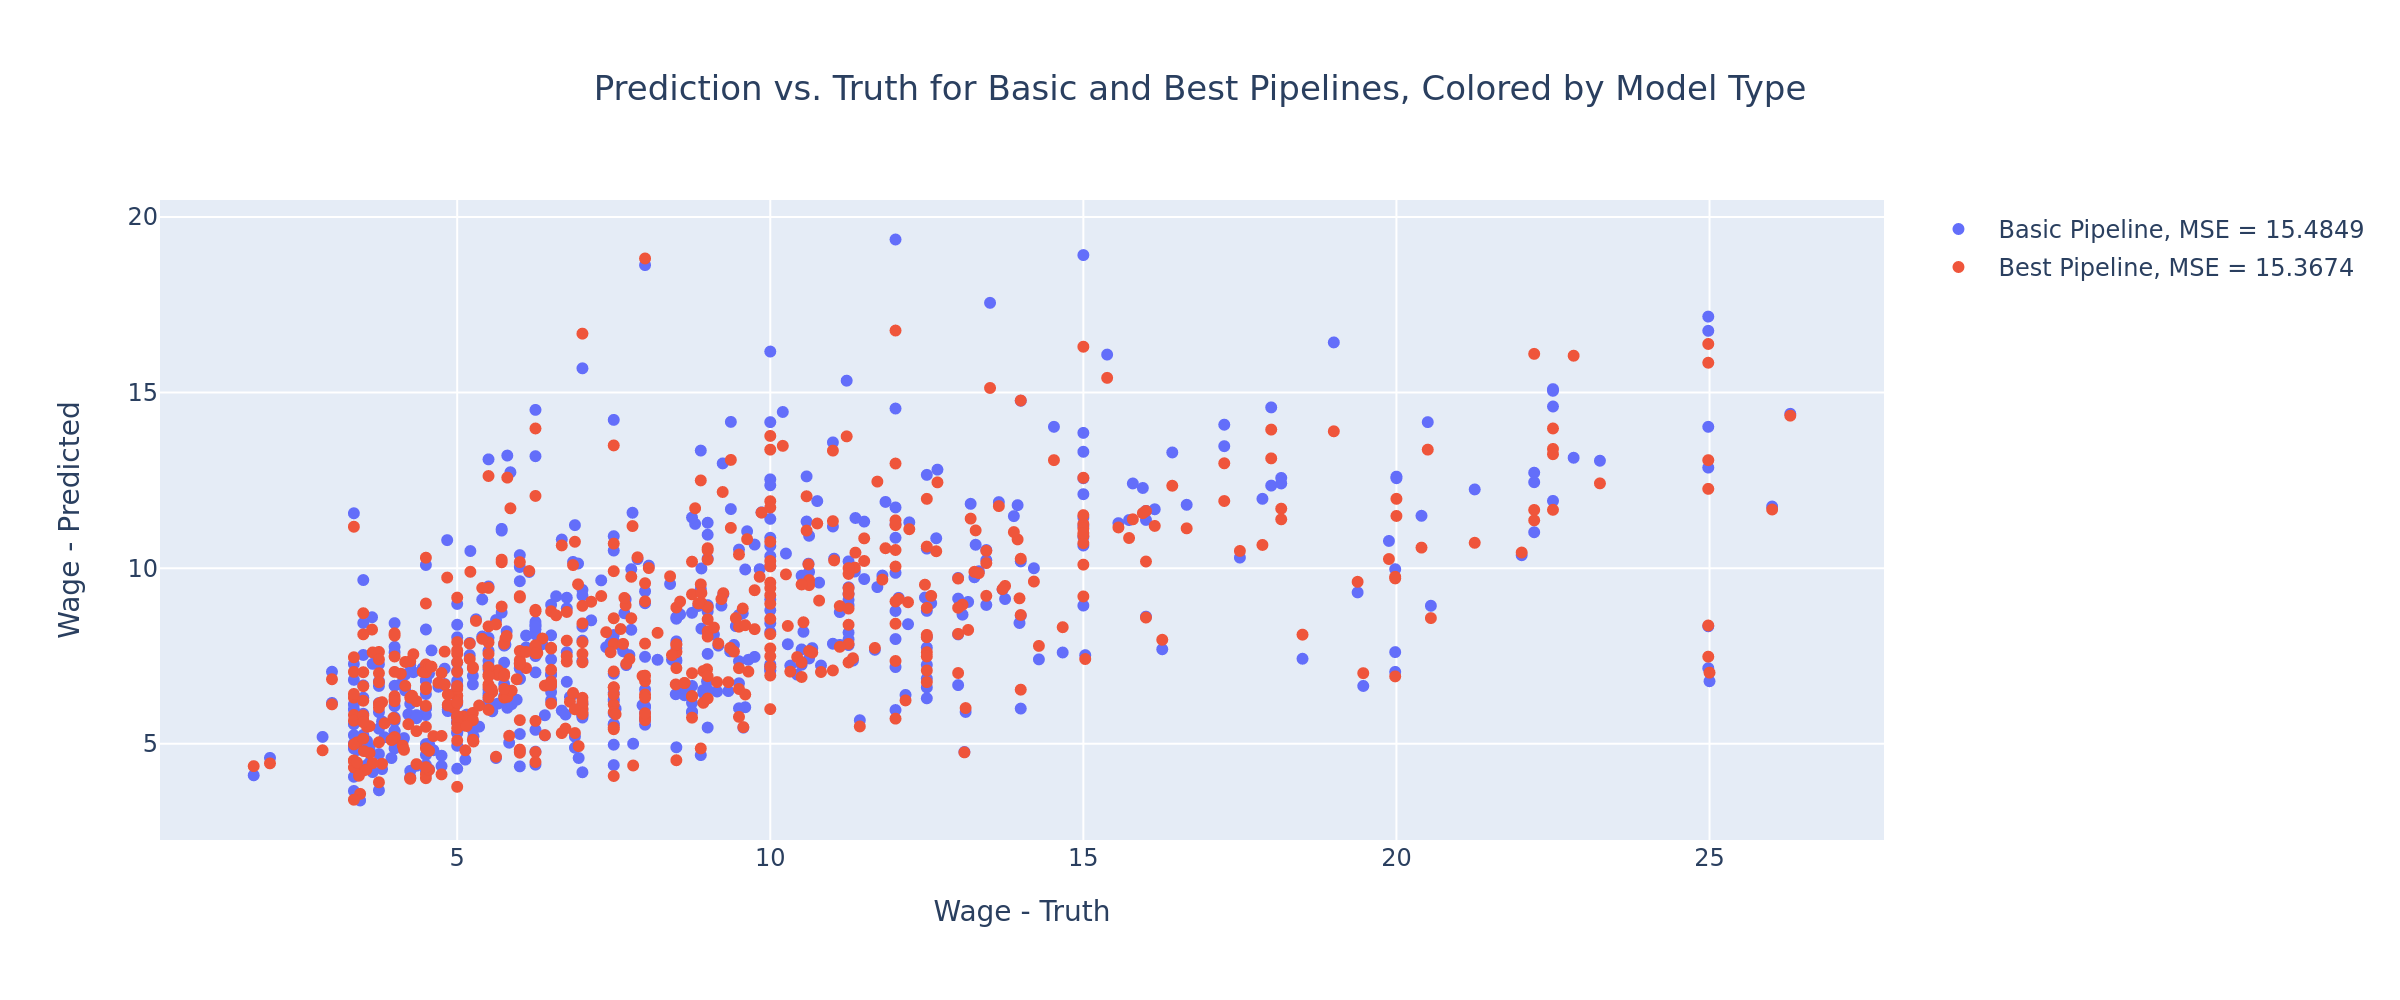

In [23]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y,
        y=y_pred,
        mode="markers",
        name="Basic Pipeline, MSE = %.4f" % mse_basic,
    )
)

fig.add_trace(
    go.Scatter(
        x=y,
        y=y_pred_best,
        mode="markers",
        name="Best Pipeline, MSE = %.4f" % mse_best,
    )
)

fig.update_layout(
    title="Prediction vs. Truth for Basic and Best Pipelines, Colored by Model Type",
    xaxis_title="Wage - Truth",
    yaxis_title="Wage - Predicted",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

In [24]:
def make_permutation_importance_DataFrame(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    features: list[str],
    **permutation_importance_kwargs,
) -> pd.DataFrame:
    # Compute the importances
    pi = permutation_importance(
        model,
        X,
        y,
        n_repeats=10,
        random_state=42,
        **permutation_importance_kwargs,
    )

    # Get a sorting by the mean importance, then build a frame with all the importances
    # where columns sorted from most important on down
    ordered_features = list(np.array(features)[np.argsort(pi.importances_mean)])[::-1]
    return pd.DataFrame(pi.importances.T, columns=features)[ordered_features]

In [25]:
# Importance per feature
model_features = numeric_features + one_hot_features
df_pi = make_permutation_importance_DataFrame(
    regression_pipe_best, X, y, model_features
)

df_pi

,numeric_EDUCATION,category_OCCUPATION,numeric_AGE,category_UNION,category_SOUTH,category_SEX,category_SECTOR,category_RACE,numeric_EXPERIENCE,category_MARR
0,0.199340,0.071626,0.058477,0.045569,0.016371,0.021457,0.017323,0.008325,0.010593,-0.000251
1,0.214308,0.070207,0.090164,0.064075,0.026215,0.028395,0.026246,0.008906,0.007353,0.003647
2,0.191488,0.080324,0.098457,0.032043,0.005759,0.011150,0.011372,0.002400,0.002646,0.003286
3,0.179831,0.087149,0.073492,0.043353,0.019267,0.006827,0.010835,0.010393,0.006685,0.002167
4,0.208385,0.088837,0.085028,0.042907,0.011641,0.024816,0.001318,0.009831,0.006508,0.003931
5,0.199908,0.081321,0.068341,0.060864,0.027683,0.020788,0.012321,0.006876,0.006850,0.004956
6,0.181549,0.071838,0.087192,0.058088,0.030201,0.021360,0.024583,0.002629,0.008087,0.003529
7,0.211037,0.100117,0.093756,0.073675,0.031559,0.017611,0.025770,0.006707,0.005195,0.004357
8,0.233459,0.093200,0.063684,0.056085,0.021741,0.036383,0.009068,0.005255,0.004508,0.001028
9,0.189395,0.079489,0.079995,0.082182,0.040881,0.026216,0.013388,0.010245,0.012116,0.002786


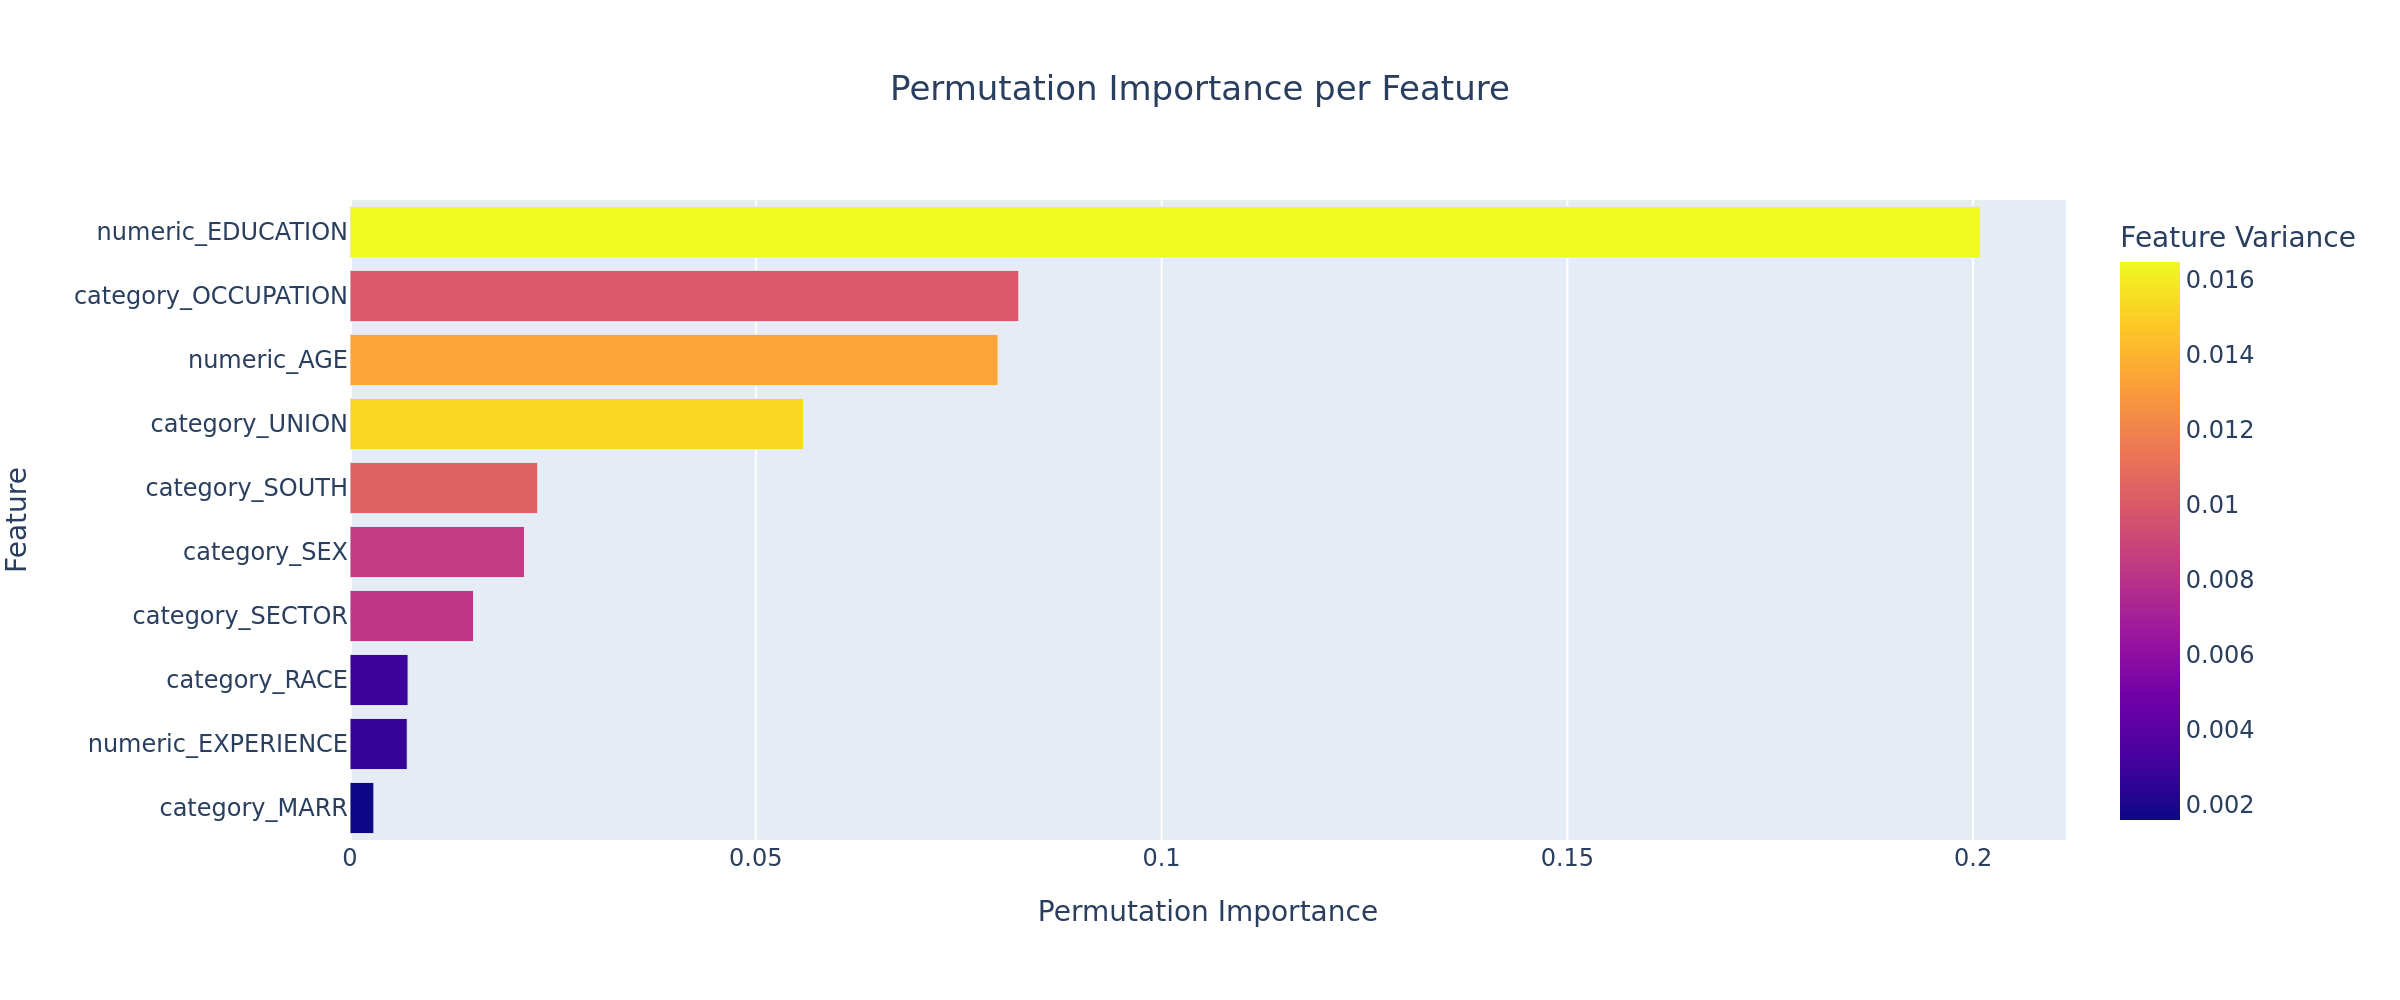

In [26]:
df_pi_reversed = df_pi[df_pi.columns[::-1]]

Image(
    px.bar(
        data_frame=df_pi_reversed.mean(),
        color=df_pi_reversed.std(),
        orientation="h",
        title="Permutation Importance per Feature",
        labels={
            "value": "Permutation Importance",
            "index": "Feature",
            "color": "Feature Variance",
        },
    )
    .update_layout(title_x=0.5)
    .to_image(format="png", width=1200, scale=2)
)

Text(0, 0.5, 'Feature')

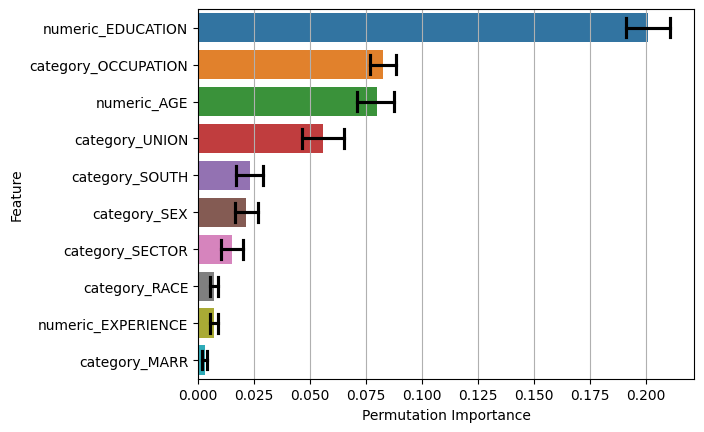

In [27]:
sns.barplot(
    df_pi,
    orient="h",
    err_kws={"color": "0.0"},
    capsize=0.5,
)

plt.xlabel("Permutation Importance")
plt.ylabel("Feature")